# Principal Component Analysis

Hypothesis: Regimes 3 and 5 are the most similar. Will this show up in a PCA plot?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

# Load Data

In [2]:
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)

(496, 44)


# Data Prep

In [3]:
train, train_y, pred_names = load_data.get_features_and_response(train)
train_X = train.copy()
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

In [4]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# PCA

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [6]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[3.95685358 2.78381332]
[0.1974438  0.13891004]
[0.1974438  0.33635384]


In [7]:
finalDf = principalDf.join(train_y)
finalDf.head()

,principal component 1,principal component 2,Regime
0,-1.975522,-0.400253,3
0,-1.975522,-0.400253,2
1,-1.958048,1.618326,5
1,-1.958048,1.618326,2
2,-1.355824,0.987270,5


# Plot 2d PCA

In [8]:
pca_means = finalDf.groupby('Regime').mean()

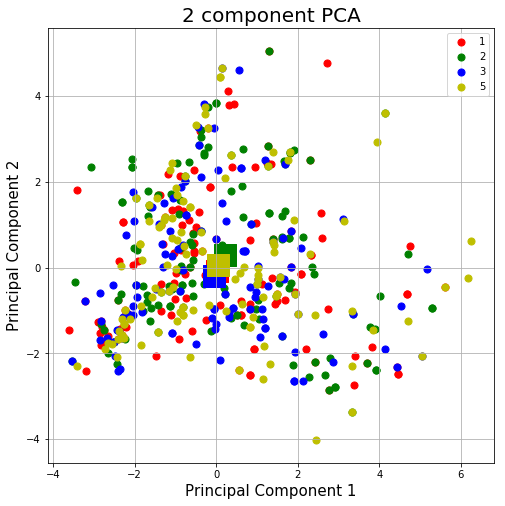

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 2, 3, 5]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Regime'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.scatter(pca_means.loc[0, 'principal component 1'], pca_means.loc[0, 'principal component 2'], c='r', s=500, marker='s')
ax.scatter(pca_means.loc[1, 'principal component 1'], pca_means.loc[1, 'principal component 2'], c='g', s=500, marker='s')
ax.scatter(pca_means.loc[2, 'principal component 1'], pca_means.loc[2, 'principal component 2'], c='b', s=500, marker='s')
ax.scatter(pca_means.loc[3, 'principal component 1'], pca_means.loc[3, 'principal component 2'], c='y', s=500, marker='s')
ax.legend(targets)
ax.grid()

In [10]:
train_X_df = pd.DataFrame(train_X, columns=pred_names)
train_X_df = train_X_df.join(train_y)
train_means = train_X_df.groupby('Regime').mean()
train_means

,Effluent,Sedimentation,New_Development,Habitat_Modification,Invasive_Algae,Fishing_Comm_Total,Fishing_NonComm_Boat_Total,Fishing_NonComm_Shore_Line,Fishing_NonComm_Shore_Net,Fishing_NonComm_Shore_Spear,SST_CLIM_M,SST_STD,CHL_CLIM_M,CHL_ANOM_F,PAR_CLIM_M,PAR_STD,WAV_CLIM_M,WAV_ANOM_F,Complexity,Depth
Regime,,,,,,,,,,,,,,,,,,,,
1,-0.005596,-0.054691,0.086454,-0.021326,-0.143122,0.060694,-0.003075,0.032372,0.000199,0.008120,0.046175,0.061435,0.036860,0.052303,-0.011916,-0.099579,0.055611,0.010793,0.023421,0.055105
2,0.148438,0.153184,0.140224,0.121555,0.218510,-0.066402,0.027455,0.010953,0.133504,0.032245,0.133355,0.003977,0.072771,-0.129502,-0.000947,0.025913,-0.116695,-0.059991,-0.034342,-0.209175
3,0.002083,0.017642,-0.035868,-0.121515,-0.052315,-0.028202,-0.038930,0.017368,-0.099447,-0.005666,0.029705,-0.006758,-0.074468,-0.075343,-0.037954,0.084084,-0.035024,0.022255,0.031080,0.196248
5,-0.120967,0.051762,-0.007582,0.036459,0.210639,-0.063006,0.010434,-0.006853,0.068452,0.063937,-0.115834,-0.111870,-0.051120,0.060308,0.027238,-0.021537,0.049673,0.010958,0.006600,-0.049942


In [11]:
l2_diffs = pd.DataFrame(index=[1, 2, 3, 5],columns=[1, 2, 3, 5])
for i in range(4):
    for j in range(4):
        l2_diffs.iloc[i,j] = np.sum(np.square(train_means.iloc[i,:] - train_means.iloc[j,:]))

In [12]:
l2_diffs

,1,2,3,5
1,0,0.425912,0.154415,0.269831
2,0.425912,0,0.487147,0.307551
3,0.154415,0.487147,0,0.283568
5,0.269831,0.307551,0.283568,0
